# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [1]:
import torch
import torch.backends
import torch.nn as nn
from collections import OrderedDict
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = "mps"
print("using device: ", device)

using device:  cuda


In [2]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
         # hyperparameters
        self.lambda_residual = 1.0
        self.kernel_regularizer = 0.0 
        self.regularization_param = 0.0
      

        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, X):
        inputs = X 
        out = self.layers(inputs)
        return out

"Complex" is the NN proposed by Giulio to solve heat and diffusion problem. I added the possibility of having different activation function which can be choosen using the string name. In most of the literature it is suggested to have at least 
two time differentiable function like "sin" and "tanh" for solving the PDE using PINNs.

In [3]:
class Swish(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


class Sin(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)
    
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['swish']:
        return Swish()
    elif name in ['sin']:
        return Sin()
    elif name in ['gelu']:
        return nn.GELU()
    else:
        raise ValueError('Unknown activation function')
    
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        # hyperparameters
        self.lambda_residual = 1.0
        self.kernel_regularizer = 0.0 
        self.regularization_param = 0.0
        self.act_string = "tanh"
        self.activation = activation(self.act_string) 
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, X):
        x = self.activation(self.ln1(self.fc1(X)))
        x = self.activation(self.ln2(self.fc2(x)))
        x = self.activation(self.ln3(self.fc3(x)))
        x = self.activation(self.ln4(self.fc4(x)))
        x = self.activation(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

In [4]:
class SineLayer(torch.nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output       

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [5]:
import SquareDomain as sd
class DirichletBC:
    def __init__(self):
        pass

    def apply(self, model, x_boundary, u_boundary, n_out, u_pred_var_list, u_train_var_list, space_dim = None, x_boundary_sym=None, boundary=None, vel_wave=None):
        u_boundary_pred = model(x_boundary)
        u_pred_var_list.append(u_boundary_pred[:, n_out])
        u_train_var_list.append(u_boundary[:, n_out])
        return boundary

In [6]:
import SquareDomain as sd
from GeneratorPoints import generator_points


class DiffClass(nn.Module):
    def __init__ (self, pretrain=False):
        super().__init__()
        self.random_seed = 423
        torch.manual_seed(self.random_seed)
        self.output_dimensions = 1
        self.time_dimensions = 1
        self.space_dimensions = 2
        self.parameter_dimensions = 0
        self.extrema_values = torch.tensor([[0,0.1],[0,2],[0,2]])
        self.boundary_points = 4
        self.list_of_bc = list([[self.ub0, self.ub0], [self.ub0, self.ub0]])
        self.pretrain = pretrain
        self.square_domain = sd.SquareDomain(self.output_dimensions,
                                             self.time_dimensions,
                                             self.space_dimensions,
                                             self.list_of_bc,
                                             self.extrema_values, "sobol")
        self.Nsamples = 1000 
        self.counter = 0
        self.full_count = 10000
        

    def __len__(self):
        return 1
    
    def true_sol_func(self,coords):
        if coords.shape[1] == 3:
            x = coords[:,1]
            y = coords[:,2]
        else:
            x = coords[:,0]
            y = coords[:,1]
        #y = coords[:,2]
        return torch.exp(x + y) * torch.cos(x + y)
    
    def ub0(self, t):
        type_BC = [DirichletBC()]
        u = self.true_sol_func(t)
        u = u.reshape(-1,1)
        return u, type_BC   

    def u0(self, t):
        ''' Adds Dirichlet boundary conditions sets the temperature'''
        #self.ini = 25 / 3000
        #u = torch.ones(t.shape[0]) * self.ini
        u = self.true_sol_func(t)
        return u

    def add_collocation_points(self, n_coll, random_seed=None):
        # uniformly sample domain and include coordinates
        x_coll, y_coll = self.square_domain.add_collocation_points(n_coll, self.random_seed)
        print(x_coll.shape)
        return x_coll, y_coll
    
    def add_boundary_points(self, n_boundary, random_seed=None):
        # boundary values and coordinates
        boundary, boundary_values = self.square_domain.add_boundary_points(n_boundary, self.random_seed)
        boundary_values = boundary_values.unsqueeze(-1)
        print(f"boundary_values: {boundary_values.shape}")
        return boundary, boundary_values
    
    def apply_bc(self, model, x_b_train, u_b_train, u_pred_var_list, u_train_var_list):
        self.square_domain.apply_boundary_conditions(model, x_b_train, u_b_train, u_pred_var_list, u_train_var_list)
         
    def apply_ic(self, model, x_u_train, u_train, u_pred_var_list, u_train_var_list):
        for j in range(self.output_dimensions):
            if x_u_train.shape[0] != 0:
                u = model(x_u_train)[:,j]
                u_pred_var_list.append(u)
                u_train_var_list.append(u_train[:])
                L2 = torch.mean((u - u_train[:])**2) / torch.mean((u_train[:])**2)
                max = torch.max(u - u_train[:])
                #print("L2 error: ", L2.item())
                #print("max error: ", max.item())

    def add_initial_points(self, n_initial, random_seed=None):
        extrema_0 = self.extrema_values[:,0] # lower bound
        extrema_f = self.extrema_values[:,1] # upper bound
        # create n number of initial points in the domain of the PDE and parameter space
        x_time_0 = generator_points(n_initial, self.time_dimensions + self.space_dimensions + self.parameter_dimensions, random_seed, "sobol", 0.1) 
        x_time_0[:,0] = torch.full(size=(n_initial,), fill_value=0.0) # initial time is 0
        # rest of the points in the domain are scaled to the size of domain
        x_time_0 = x_time_0 * (extrema_f - extrema_0) + extrema_0
        y_time_0 = self.u0(x_time_0)
        print(y_time_0.shape)
        return x_time_0, y_time_0

    def compute_residual(self, net, x_f_train ):
        self.network = net
        x_f_train.requires_grad = True
        u = self.network(x_f_train)[:,0].reshape(-1) 
        # compute gradient of u wrt x
        grad_u = torch.autograd.grad(u, x_f_train, grad_outputs=torch.ones(u.shape).to(device), create_graph=True)[0] 
        grad_u_t = grad_u[:,0]
        grad_u_x = grad_u[:,1]
        grad_u_y = grad_u[:,2]
        # compute second order derivatives
        grad_u_xx = torch.autograd.grad(grad_u_x, x_f_train, grad_outputs=torch.ones(grad_u_x.shape).to(device), create_graph=True)[0][:,1]
        grad_u_yy = torch.autograd.grad(grad_u_y, x_f_train, grad_outputs=torch.ones(grad_u_y.shape).to(device), create_graph=True)[0][:,2]
        # compute residual
        residual = grad_u_xx.reshape(-1,) + grad_u_yy.reshape(-1,)
        residual = grad_u_t.reshape(-1,) - residual
        return residual


In [7]:
class DefineDataset:
    def __init__(self, diff, n_collocation, n_boundary, n_initial, n_internal, batches, random_seed, shuffle=False):
        self.n_collocation = n_collocation
        self.n_boundary = n_boundary
        self.n_initial = n_initial
        self.n_internal = n_internal
        self.batches = batches
        self.random_seed = random_seed
        self.shuffle = shuffle
        self.diff = diff
        
        self.space_dimensions = diff.space_dimensions
        self.output_dimensions = diff.output_dimensions
        self.time_dimensions = diff.time_dimensions
        self.input_dimensions = self.space_dimensions + self.time_dimensions

        self.n_samples = n_collocation + 2 * n_boundary * self.space_dimensions + n_initial * self.time_dimensions + n_internal
        self.BC = None
        self.data_coll = None
        self.data_boundary = None
        self.data_initial_internal = None

        if self.batches == "full":
            self.batches = int(self.n_samples)
        else:
            self.batches = int(batches)
        
    def assemble_dataset(self, safe=True):

        fraction_coll = int(self.batches * self.n_collocation / self.n_samples)
        fraction_boundary = int(self.batches * 2* self.n_boundary * self.space_dimensions / self.n_samples)
        fraction_initial = int(self.batches * self.n_initial / self.n_samples)
        fraction_internal = int(self.batches * self.n_internal / self.n_samples)

        x_coll, y_coll = self.diff.add_collocation_points(self.n_collocation, self.random_seed)
        x_b, y_b = self.diff.add_boundary_points(self.n_boundary, self.random_seed)
        print(f"boundary shapes: {x_b.shape}, {y_b.shape}")
        
        # test if the boundary points are correct
        y_b, _ = self.diff.ub0(x_b)
        #assert torch.equal(y_b,u_b[0])
        

        x_time_internal, y_time_internal = self.diff.add_initial_points(self.n_initial, self.random_seed)
        
        print (x_time_internal.shape)
        print(y_time_internal.shape)

        """ if self.n_internal != 0:
            x_internal, y_internal = self.diff.add_internal_points(self.n_internal, self.random_seed)
            print (x_internal.shape, y_internal.shape)
            x_time_internal = torch.cat((x_time_internal, x_internal), 0)
            y_time_internal = torch.cat((y_time_internal, y_internal), 0)
         """
        print("##############################################")
        print("collocation: ", x_coll[1:10,:], x_coll.shape, y_coll.shape)
        print(' collocation_max: ', torch.max(x_coll, 0)[0], '\n', 'collocation_min: ', torch.min(x_coll, 0)[0])
        #print('internal:', x_time_internal[1:10,:], x_time_internal.shape, y_time_internal.shape)

        if self.n_collocation == 0:
            self.data_coll = DataLoader(torch.utils.data.TensorDataset(x_coll, y_coll), batch_size = 1, shuffle = False)
        else:
            self.data_coll = DataLoader(torch.utils.data.TensorDataset(x_coll, y_coll), batch_size = fraction_coll, shuffle = self.shuffle)

        if self.n_boundary == 0:
            self.data_boundary = DataLoader(torch.utils.data.TensorDataset(x_b, y_b), batch_size = 1, shuffle = False)
        else:
            self.data_boundary = DataLoader(torch.utils.data.TensorDataset(x_b, y_b), batch_size = fraction_boundary, shuffle = self.shuffle)

        if fraction_internal == 0 and fraction_initial == 0:
            self.data_initial_internal = DataLoader(torch.utils.data.TensorDataset(x_time_internal, y_time_internal), batch_size = 1, shuffle = False)
        else:
            self.data_initial_internal = DataLoader(torch.utils.data.TensorDataset(x_time_internal, y_time_internal), batch_size = fraction_initial + fraction_internal, 
                                                    shuffle = self.shuffle)
            
        if safe:
            folder = "Points"
            if (not os.path.exists(folder)):
                os.makedirs(folder)

            torch.save(x_coll, f"{folder}/x_coll_{folder}.pt")
            torch.save(y_coll, f"{folder}/y_coll_{folder}.pt")
            torch.save(x_b, f"{folder}/x_b_{folder}.pt")
            torch.save(y_b, f"{folder}/y_b_{folder}.pt")

            torch.save(x_time_internal, f"{folder}/x_time_internal_{folder}.pt")
            torch.save(y_time_internal, f"{folder}/y_time_internal_{folder}.pt")
            print("Saved points dataset")


Main class of the NN to solve the heat diffusion. Learning rate choosen is "rather" big 0.01 and can be reduced 10x

This defines the custom loss for the NN. We have also regularization of the network using `regularization` function

In [8]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,  diff, net,  x_u_train, u_train, x_b_train, u_b_train, x_f_train, dataclass):
        # fetch some hyperparameters
        lambda_residual = net.lambda_residual
        lambda_reg = net.regularization_param
        order_regularizer = net.kernel_regularizer

        u_pred_bound_list = list()
        u_train_bound_list = list()
        u_pred_ini_list = list()
        u_train_ini_list = list()
        
        if x_b_train.shape[0] != 0:
            # apply boundary conditions
            diff.apply_bc(net, x_b_train, u_b_train, u_pred_bound_list, u_train_bound_list)
        if x_u_train.shape[0] != 0:
            # apply initial conditions
            diff.apply_ic(net, x_u_train, u_train, u_pred_ini_list, u_train_ini_list)
        u_pred_bound_vars = torch.cat(u_pred_bound_list,0)
        u_train_bound_vars = torch.cat(u_train_bound_list,0)
        u_pred_ini_vars = torch.cat(u_pred_ini_list,0)
        u_train_ini_vars = torch.cat(u_train_ini_list,0)

        assert not torch.isnan(u_pred_bound_vars).any()
        assert not torch.isnan(u_train_bound_vars).any()

        loss_bound = torch.mean(abs(u_pred_bound_vars - u_train_bound_vars)**2)
        loss_ini = torch.mean(abs(u_pred_ini_vars - u_train_ini_vars)**2)
        

        res = diff.compute_residual(net,x_f_train)
        loss_res = torch.mean(abs(res)**2)
        loss_vars = loss_ini + loss_bound
        loss_reg = regularization(net, order_regularizer)

        loss_v = lambda_residual * loss_vars + 2 * loss_res + lambda_reg * loss_reg
        print("Total loss:", loss_v.detach().cpu().numpy().round(6), "|Boundary loss: ", torch.log10(loss_bound).detach().cpu().numpy().round(4), "|Initial residual: ", 
              torch.log10(loss_ini).detach().cpu().numpy().round(4), "|PDE loss ", torch.log10(loss_res).detach().cpu().numpy().round(6))
        return loss_v, loss_vars, loss_res
    
def regularization(model, p):
    reg_loss = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            reg_loss += torch.norm(param, p)
    return reg_loss

In [9]:
import ChooseOptimizer as co
learn_rate = 0.01
class Net:
    def __init__(self, model = "diff"):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        # build model
        if model == "diff":
            self.model = DiffNet(
               input_size=3,
               hidden_size=256,
               output_size=1,
               depth=6,
               act=torch.nn.Tanh).to(device)
        elif model == "siren":
            self.model = Siren(in_features=4, 
                               out_features=2, 
                               hidden_features=51, 
                               hidden_layers=11, 
                               outermost_linear=True).to(device)
        elif model == "complex":
            self.model = ComplexHeatEquationNet().to(device)
        self.model_input = {}
        self.gt = {}

        # optimizer
        params = (self.model.parameters(), learn_rate, 100, None, 100, 1e-7, 1e-7, "strong_wolfe")
        self.optimizer = self.configure_optimizers("LBFGS", *params)
        self.iter = 0

    def configure_optimizers(self, optimizer_name, *params):
        return co.choose_optimizer(optimizer_name, *params)
        
    def train(self, diff, epochs, training_set, verbose = True, freq = 1):
        train_losses = list([np.inf, np.inf, np.inf])
        # unpack training data in different sets
        training_coll = training_set.data_coll
        training_boundary = training_set.data_boundary
        training_initial_internal = training_set.data_initial_internal

        for epoch in range(epochs):
            if verbose and epoch % freq == 0:
                print(f"=============== {epoch} ===============")

            for step, ((x_coll_train, u_coll_train), (x_b_train, u_b_train), (x_u_train, u_train)) in enumerate(zip(training_coll, training_boundary, training_initial_internal)):

                x_coll_train = x_coll_train.to(device)
                x_b_train = x_b_train.to(device)
                u_b_train = u_b_train.to(device)
                x_u_train = x_u_train.to(device)
                u_train = u_train.to(device)

                def closure():
                    self.optimizer.zero_grad()
                    loss_f, loss_vars, loss_pde = CustomLoss().forward(diff, self.model, x_u_train, u_train, x_b_train, u_b_train, x_coll_train, training_set)
                    loss_f.backward()
                    train_losses[0] = loss_f
                    train_losses[1] = loss_vars
                    train_losses[2] = loss_pde
                    return loss_f

                self.optimizer.step(closure=closure)
        return train_losses

Using the xavier and kaiming initialization for the balance of the weights

In [48]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

            # torch.nn.init.xavier_uniform_(m.bias)
            # m.bias.data.fill_(0)

    model.apply(init_weights)

def init_kaiming(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='tanh')
            torch.nn.init.uniform_(m.bias, 0, 1)

            # torch.nn.init.xavier_uniform_(m.bias)
            # m.bias.data.fill_(0)

    model.apply(init_weights)


In [66]:
import matplotlib.pyplot as plt
def get_activation(model):
    """ add activations """
    legends = []
    dict_act = {}

     # Hook function to capture activations
    def get_activation(name:str):
        def hook_fn(module, input, output):
            dict_act[name] = output.detach()
        return hook_fn
    
    # Register hook to each Tanh layer
    hooks = []
    for mod in model.modules():
        if isinstance(mod, torch.nn.Sequential):
            print(mod)
            for name, layer in mod.named_children():
                #print(layer)
                if isinstance(layer, torch.nn.Tanh):
                    print(name)
                    layer.register_forward_hook(get_activation(name))
    return dict_act, hooks

def plot_activations(dict_act, save=False):
    """ plot activations """
    plt.figure()
    legends = []
    # get activations
    for name, activation in dict_act.items():
        activation = activation.to('cpu')
        print(f'layer {name}: mean: {activation.mean():.2f} std: {activation.std():.2f}, saturated: {(activation.abs() > 0.97).float().mean()*100:.2f}%')
        # plot
        hy, hx = torch.histogram(activation.detach(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
                    
        legends.append(f'layer {name}')
        if save:
            plt.savefig('activation_weights.png')
    plt.legend(legends)
    plt.show()

Sequential(
  (input): Linear(in_features=3, out_features=256, bias=True)
  (input_activation): Tanh()
  (hidden_0): Linear(in_features=256, out_features=256, bias=True)
  (activation_0): Tanh()
  (hidden_1): Linear(in_features=256, out_features=256, bias=True)
  (activation_1): Tanh()
  (hidden_2): Linear(in_features=256, out_features=256, bias=True)
  (activation_2): Tanh()
  (hidden_3): Linear(in_features=256, out_features=256, bias=True)
  (activation_3): Tanh()
  (hidden_4): Linear(in_features=256, out_features=256, bias=True)
  (activation_4): Tanh()
  (hidden_5): Linear(in_features=256, out_features=256, bias=True)
  (activation_5): Tanh()
  (output): Linear(in_features=256, out_features=1, bias=True)
)
input_activation
activation_0
activation_1
activation_2
activation_3
activation_4
activation_5
layer input_activation: mean: 0.44 std: 0.24, saturated: 0.00%
layer activation_0: mean: 0.41 std: 0.38, saturated: 0.55%
layer activation_1: mean: 0.33 std: 0.48, saturated: 0.55%
laye

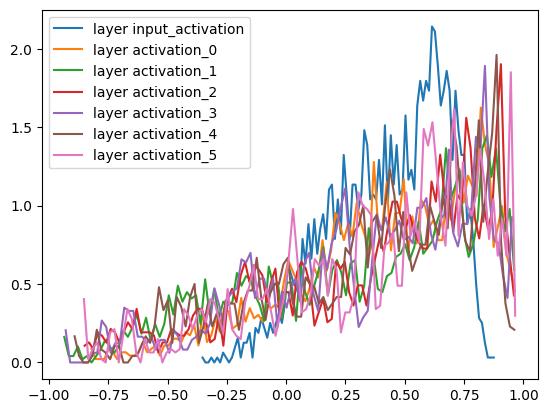

In [67]:
#net.train(diff, 1, training_set, verbose=True, freq=1)
act, hooks = get_activation(net.model)
init_kaiming(net.model)
net.model(torch.randn(10,3).to(device))
plot_activations(act)

None
sobol
torch.Size([1000, 3])
sobol
sobol
sobol
sobol
boundary_values: torch.Size([2000, 1, 1])
boundary shapes: torch.Size([2000, 3]), torch.Size([2000, 1, 1])
sobol
torch.Size([500])
torch.Size([500, 3])
torch.Size([500])
##############################################
collocation:  tensor([[0.0244, 0.4883, 1.2695],
        [0.0744, 1.4883, 0.2695],
        [0.0994, 0.9883, 0.7695],
        [0.0494, 1.9883, 1.7695],
        [0.0369, 0.7383, 0.0195],
        [0.0869, 1.7383, 1.0195],
        [0.0619, 0.2383, 1.5195],
        [0.0119, 1.2383, 0.5195],
        [0.0088, 0.1758, 0.3320]]) torch.Size([1000, 3]) torch.Size([1000, 1])
 collocation_max:  tensor([0.1000, 1.9990, 1.9980]) 
 collocation_min:  tensor([9.7656e-05, 1.9531e-03, 1.9531e-03])
Saved points dataset
Sequential(
  (input): Linear(in_features=3, out_features=256, bias=True)
  (input_activation): Tanh()
  (hidden_0): Linear(in_features=256, out_features=256, bias=True)
  (activation_0): Tanh()
  (hidden_1): Linear(in_feat

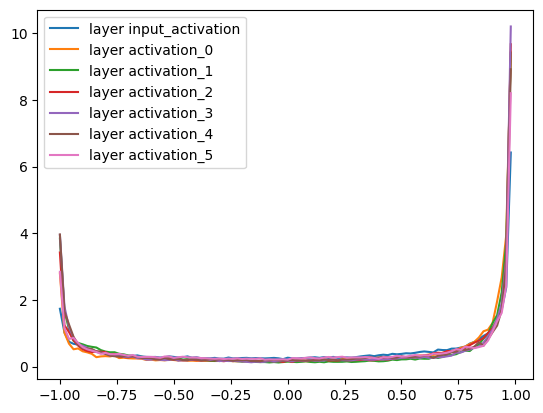

In [49]:
# dataset creation
N_b_train = 500
N_i_train = 500
N_coll_train = 1000
N_int_train = 500
diff = DiffClass()
training_set = DefineDataset(diff, N_coll_train, N_b_train, N_i_train, N_int_train, batches = 1024, random_seed=32, shuffle=True)
training_set.assemble_dataset()
# model creation 
net = Net(model="diff") 
init_kaiming(net.model)
# hook to get activations
act, hooks = get_activation(net.model)
net.train(diff, 100, training_set, verbose=True, freq=1)
plot_activations(act)
# torch compile the model
#net.model = torch.compile(net.model)
#net.train(diff, 100, training_set=training_set)

4


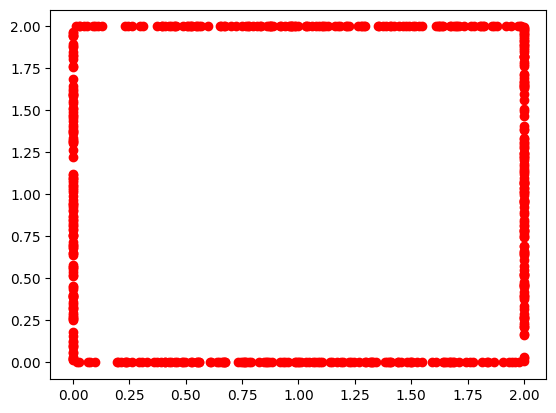

"\nplt.plot(boundary[0][:,1].numpy(), boundary[0][:,2].numpy(), 'ro')\nplt.plot(boundary[1].numpy(), boundary[1].numpy(), 'go')\n\n\n# initial points\ninitial_points = training_set.data_initial_internal\ninitial_points = next(iter(initial_points))\nprint(len(initial_points))\nprint(initial_points[0].shape)\nprint(type(initial_points[0]))\nplt.plot(initial_points[0][:,1].numpy(), initial_points[0][:,2].numpy(), 'bo')\nplt.show()\n\n# collocation points\ncoll_points = training_set.data_coll\ncoll_points = next(iter(coll_points))\nprint(len(coll_points))\nprint(coll_points[0].shape)\nprint(type(coll_points[0]))\nplt.plot(coll_points[0][:,1].numpy(), coll_points[0][:,2].numpy(), 'go')\nplt.show() "

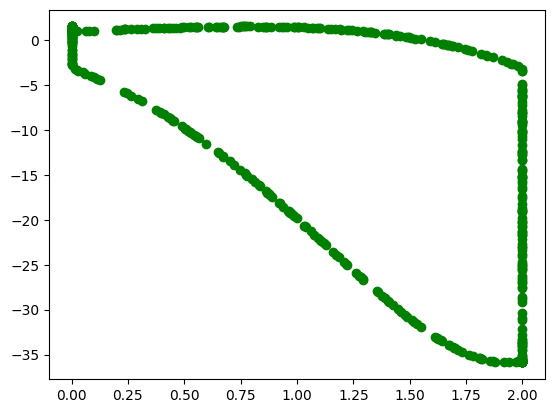

In [ ]:
import matplotlib.pyplot as plt
boundary = training_set.data_boundary
x_boundary, u_boundary = next(iter(boundary))
print(len(boundary))
plt.plot(x_boundary[:,1].numpy(), x_boundary[:,2].numpy(), 'ro')
plt.show()
plt.plot(x_boundary[:,1].numpy(), u_boundary.numpy(), 'go')
'''
plt.plot(boundary[0][:,1].numpy(), boundary[0][:,2].numpy(), 'ro')
plt.plot(boundary[1].numpy(), boundary[1].numpy(), 'go')


# initial points
initial_points = training_set.data_initial_internal
initial_points = next(iter(initial_points))
print(len(initial_points))
print(initial_points[0].shape)
print(type(initial_points[0]))
plt.plot(initial_points[0][:,1].numpy(), initial_points[0][:,2].numpy(), 'bo')
plt.show()

# collocation points
coll_points = training_set.data_coll
coll_points = next(iter(coll_points))
print(len(coll_points))
print(coll_points[0].shape)
print(type(coll_points[0]))
plt.plot(coll_points[0][:,1].numpy(), coll_points[0][:,2].numpy(), 'go')
plt.show() '''


sobol
shape x_boundary_0 torch.Size([10, 3])
sobol
sobol
shape x_boundary_0 torch.Size([10, 3])
sobol
boundary_values: torch.Size([40, 1, 1])
torch.Size([40, 2])


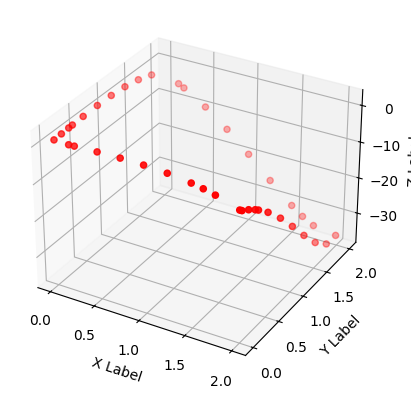

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection, but is otherwise unused.

# Assuming 'boundary' is already defined as shown in your code snippet

# Extract x, y, and z coordinates
x_boundary, u_boundary = diff.add_boundary_points(10, 32)
x = x_boundary[:,1]
y = x_boundary[:,2]
#tn = x_boundary[:,0]
z = u_boundary.numpy()
print(x_boundary[:,1:3].shape)
z = diff.ub0(x_boundary)[0].detach().numpy()

# Create a new figure for the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot using scatter
ax.scatter(x, y, z, c='r', marker='o')

# Set labels for axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

In [ ]:
diff.add_boundary_points(32)
device = "cuda:0"
boundary[0] = boundary[0].to(device)
boundary[1] = boundary[1].to(device)


diff.apply_bc(net.model, boundary[0], boundary[1],[], [])
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection, but is otherwise unused.

# Assuming 'boundary' is already defined as shown in your code snippet

# Extract x, y, and z coordinates
x = boundary[0][:,1].cpu().numpy()
y = boundary[0][:,2].cpu().numpy()
z = boundary[1].cpu().numpy()

# Create a new figure for the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot using scatter
ax.scatter(x, y, z, c='r', marker='o')

# Set labels for axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

sobol
shape x_boundary_0 torch.Size([32, 3])
sobol
sobol
shape x_boundary_0 torch.Size([32, 3])
sobol
boundary_values: torch.Size([128, 1, 1])


TypeError: 'DataLoader' object is not subscriptable

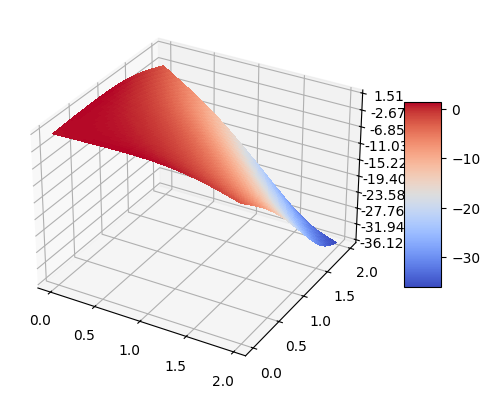

In [53]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')

x = np.arange(0,2,0.02)
y = np.arange(0,2,.02)
xm, ym = np.meshgrid(x,y)

x = np.ravel(xm).reshape(-1,1)
y = np.ravel(ym).reshape(-1,1)

x_input = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
y_input = Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
t_input = Variable(torch.ones_like(x_input)*0.1, requires_grad=True).to(device)
X = torch.cat([t_input, x_input,y_input],1)

u_pred = net.model(X)
um = u_pred.data.cpu().numpy()
um = um.reshape(xm.shape)

surf = ax.plot_surface(xm, ym, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [54]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,0.1)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)

In [55]:
mse

4.232645590716692

## Analytical solution to heat equation

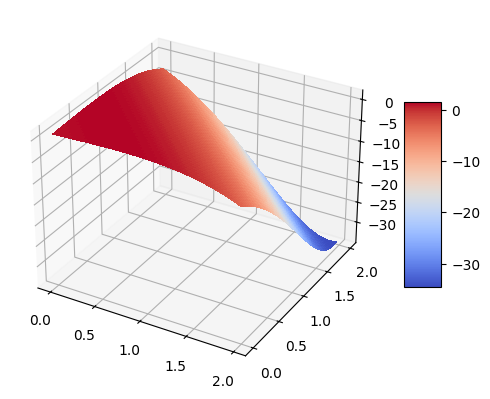

In [56]:
fig2 = plt.figure()
ax2 = plt.axes(projection='3d')

xm = np.arange(0,2,0.02)
ym = np.arange(0,2,.02)
xm, ym = np.meshgrid(xm,ym)
anal_sol = solution(xm,ym,0.01)

surf = ax2.plot_surface(xm, ym, anal_sol, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig2.colorbar(surf, shrink=.5, aspect=5)
plt.show()